In [ ]:
# Mound google drive
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Install necessary packages

In [ ]:
!pip install simpleitk
!pip install ANTs
!pip install nipype

Install ANTs package

In [ ]:
!cp '/content/gdrive/MyDrive/Colab/DeepSeg_Paper/ANTs-28-03-2019.7z' ./
!7z x ANTs-28-03-2019.7z

In [ ]:
!cp bin/* /usr/local/bin

In [ ]:
!which antsRegistration # test registration

## Preprocess data

In [ ]:
!python preprocess.py

### divide the preprocessed data into folders for different mri modalities

In [ ]:
# divide the preprocessed data into folders for different mri modalities
from config import *
import glob, os
import shutil

config["modalities"] = ['seg']
#config["modalities"] = ["FLAIR", "t1", "t1ce", "t2"]
for subject_folder in glob.glob(os.path.join(config['brats_path'], "*", "*")):
        if os.path.isdir(subject_folder):
            subject = os.path.basename(subject_folder)

            for name in config["modalities"]:
              search_file_list = glob.glob(os.path.join(subject_folder,"*"+name+".nii"))
              modalities_folder = os.path.join(config['preprocessed_brats'],"image_" + name)
              if not os.path.exists(modalities_folder):
                  os.makedirs(modalities_folder)

              for search_file in search_file_list:
                modalities_new_path = os.path.join(modalities_folder, os.path.basename(search_file))
                shutil.copyfile(search_file, modalities_new_path)




## Convert into 2D images

In [ ]:
!python preprocess_2d_images.py

### Make dataset folder and divide the images into train/valid

Move images

In [ ]:
from config import *
import shutil

if not os.path.exists(config['dataset_path']):
    os.mkdir(config['dataset_path'])
if not os.path.exists(config['train_images']):
    os.mkdir(config['train_images'])

if not os.path.exists(config['val_images']):
    os.mkdir(config['val_images'])



config["modalities"] = ["FLAIR", "t1", "t1ce", "t2"]
for name in config["modalities"]:
  for subject_folder in glob.glob(os.path.join(config['preprocessed_brats_imgs'], "image_" + name, "BraTS19_[0-9]*")):  # move validation data

     if os.path.isdir(subject_folder):
        subject = os.path.basename(subject_folder)

        # make sub directory first : image_FLAIR
        val_img_dir = os.path.join(config['val_images'], "image_" + name)

        if not os.path.exists(val_img_dir):
            os.mkdir(val_img_dir)

        # move to subdirectory
        for path in os.listdir(subject_folder):
            dataset_val_img_dir = os.path.join(val_img_dir, subject)
            if not os.path.exists(dataset_val_img_dir):
                os.mkdir(dataset_val_img_dir)
            shutil.move(os.path.join(subject_folder,path), dataset_val_img_dir)

  for subject_folder in glob.glob(os.path.join(config['preprocessed_brats_imgs'], "image_" + name, "BraTS19_[A-Z]*")):  # training data
     #print(subject_folder)
     if os.path.isdir(subject_folder):
        subject = os.path.basename(subject_folder)

        # make sub directory first : image_FLAIR
        train_image_dir = os.path.join(config['train_images'], "image_" + name)

        if not os.path.exists(train_image_dir):
            os.mkdir(train_image_dir)

        # move to subdirectory
        for path in os.listdir(subject_folder):
            dataset_train_img_dir = os.path.join(train_image_dir, subject)
            if not os.path.exists(dataset_train_img_dir):
                os.mkdir(dataset_train_img_dir)
            # print(os.path.join(subject_folder,path))
            # print(dataset_train_img_dir)
            shutil.move(os.path.join(subject_folder,path), dataset_train_img_dir)

Move truth

In [ ]:
from config import *
import glob, os
import shutil

config['dataset_path'] = './data/dataset_brats19_new/' # path to the dataset containing 2d images (train_images, train_segmentation, ... etc)
config['train_annotations'] = config['dataset_path'] + 'train_segmentation/' + config['train_label']
config['val_annotations'] = config['dataset_path'] + 'val_segmentation/' + config['train_label']
config['preprocessed_brats_imgs'] = './data/BraTS19_train_images_new/'

if not os.path.exists(config['dataset_path'] + 'train_segmentation/'):
    os.mkdir(config['dataset_path'] + 'train_segmentation/')
if not os.path.exists(config['dataset_path'] + 'val_segmentation/'):
    os.mkdir(config['dataset_path'] + 'val_segmentation/')
# move truth - training
for subject_folder in glob.glob(os.path.join(config['preprocessed_brats_imgs'], config['train_label'], "BraTS19_[A-Z]*")):
    if os.path.isdir(subject_folder):
        subject = os.path.basename(subject_folder)

    if not os.path.exists(config['train_annotations']): # make sub-directory first
        os.mkdir(config['train_annotations'])

    # move to subdirectory
    for path in os.listdir(subject_folder):
        dataset_train_seg_dir = os.path.join(config['train_annotations'], subject)
        if not os.path.exists(dataset_train_seg_dir):
            os.mkdir(dataset_train_seg_dir)
        # print(os.path.join(subject_folder,path))
        # print(dataset_train_seg_dir)
        shutil.move(os.path.join(subject_folder,path), dataset_train_seg_dir)


# move truth - validation
for subject_folder in glob.glob(os.path.join(config['preprocessed_brats_imgs'], config['train_label'], "BraTS19_[0-9]*")):
    if os.path.isdir(subject_folder):
        subject = os.path.basename(subject_folder)

    if not os.path.exists(config['val_annotations']): # make sub-directory first
        os.mkdir(config['val_annotations'])

    # move to subdirectory
    for path in os.listdir(subject_folder):
        dataset_val_seg_dir = os.path.join(config['val_annotations'], subject)
        if not os.path.exists(dataset_val_seg_dir):
            os.mkdir(dataset_val_seg_dir)
        #print(os.path.join(subject_folder,path))
        #print(dataset_val_seg_dir)
        shutil.move(os.path.join(subject_folder,path), dataset_val_seg_dir)

## Training

In [ ]:
!pip install keras_applications

In [ ]:
!python train.py

In [ ]:
with open('history.pkl', 'rb') as file:

    # Call load method to deserialze
    hist = pickle.load(file)

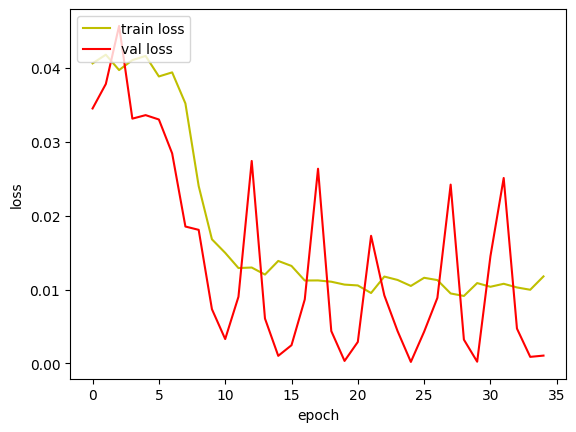

In [ ]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()
loss_ax.plot(hist['loss'], 'y', label='train loss')
loss_ax.plot(hist['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

In [ ]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()
loss_ax.plot(hist['dice_argmax'], 'y', label='dice arg max')
loss_ax.plot(hist['val_dice_argmax'], 'r', label='val dice arg max')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('dice arg max')
loss_ax.legend(loc='upper left')

Write to valid_cases_unique.txt

In [ ]:
import os, glob
from config import *
files = glob.glob (os.path.join(config['val_images'],"*","*"))
print(files)
with open (config['val_cases_file'], 'w') as in_files:
    for eachfile in files: in_files.write(eachfile+'\n')

Predict from model

In [ ]:
!python predict.py

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1,2)

im70_truth = cv2.imread("./data/dataset_brats19/val_segmentation/truth_complete/BraTS19_2013_0_1/BraTS19_2013_0_1_70.png")
print(np.count_nonzero(im70_truth>0))
ax1.imshow(im70_truth*100)

im70 = cv2.imread("./data/dataset_brats19/val_images/image_FLAIR/BraTS19_2013_0_1/BraTS19_2013_0_1-50.png")
ax2.imshow(im70)

plt.show()

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
im_test = cv2.imread("/content/drive/MyDrive/Colab/DeepSeg_Paper/data/dataset_brats19/train_segmentation/truth_complete/BraTS19_CBICA_AAB_1/BraTS19_CBICA_AAB_1_0.png")
print(im_test.shape)

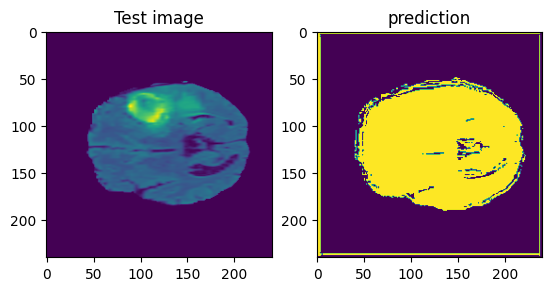

In [ ]:
import nibabel as nib
import matplotlib.pyplot as plt
test_load = nib.load("/content/drive/MyDrive/Colab/DeepSeg_Paper/data/BraTS19_train_nii/image_FLAIR/BraTS19_2013_10_1_flair.nii").get_fdata()
test_load_pred = nib.load("/content/drive/MyDrive/Colab/DeepSeg_Paper/preds/UNet_UNet_nifti_240/BraTS19_2013_10_1.nii").get_fdata()

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.imshow(test_load[:,:,70])
ax1.set_title("Test image")
ax2.imshow(test_load_pred[:,:,70])
ax2.set_title("prediction")
plt.show()

In [ ]:
from google.colab import drive
drive.flush_and_unmount()